## Identify the synthetic lethal interaction by outlier statistics *-- Putative paralog pairs*

Based on the threshold identified in random shuffling, we will use this threshold to further filter the putative paralog pairs. 

**Input**
- Integrated dataset (contain A1, A2 information, A2 CNV, A1 gene dependency scores): HUGE_dataset.csv
- Processed RNA-seq data (Z-score log2(TPM+1)): rnaseq_zlogtpm.csv

**Output**

In [1]:
## Import modules
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted

In [2]:
## Import dataset 
huge_df = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/03_HUGE_dataset/HUGE_dataset.csv', index_col=None)

In [3]:
rnaseq_zlogtpm = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/rnaseq_zlogtpm.csv', index_col = None)
rnaseq_zlogtpm = rnaseq_zlogtpm.rename(columns = {rnaseq_zlogtpm.columns[0]:'BROAD_ID'})

In [4]:
huge_df.loc[huge_df['A2_CNV'] != 'Deletion', 'A2_CNV'] = 'Others'
huge_df.loc[huge_df['A2_CNV'] == 'Deletion', 'A2_CNV'] = 'Homozygous deletion' 

**Filter putative paralog pairs with robust Z-score lower than threshold**

In [5]:
threshold = -3.6
putative_SLs_df = huge_df[(huge_df['A2_CNV'] == 'Homozygous deletion') & (huge_df['A1_RobustZscore'] <= threshold) & (huge_df['A1_Chronosscore'] <= -0.6)]

## SL list based on robust Z-score
putative_SLs_robustZ_ls = set(putative_SLs_df.pairs_to_test_symbol)
# putative_SLs_robustZ_ls = set(putative_SLs_df.sorted_gene_pair)
print('Number of SL pairs in our dataset based on robust z-score threshold = ' + str(threshold) +':', len(putative_SLs_robustZ_ls))

Number of SL pairs in our dataset based on robust z-score threshold = -3.6: 17


In [6]:
threshold = -2.8
putative_SLs_df = huge_df[(huge_df['A2_CNV'] == 'Homozygous deletion') & (huge_df['A1_StandardZscore'] <= threshold) & (huge_df['A1_Chronosscore'] <= -0.6)]

## SL list based on standard Z-score
putative_SLs_standardZ_ls = set(putative_SLs_df.pairs_to_test_symbol)
# putative_SLs_standardZ_ls = set(putative_SLs_df.sorted_gene_pair)
print('Number of SL pairs in our dataset based on standard z-score threshold = ' + str(threshold) +':', len(putative_SLs_standardZ_ls))
# FNIP2_FNIP1

Number of SL pairs in our dataset based on standard z-score threshold = -2.8: 17


Overlapping of putative SLs based on robust Z-score and standard Z-score

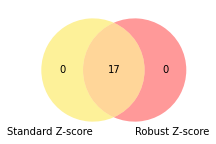

In [7]:
f, ax = plt.subplots(1,1, figsize=(3,3))
v = venn2_unweighted(subsets = (putative_SLs_standardZ_ls,
                                putative_SLs_robustZ_ls), set_labels = ('Standard Z-score','Robust Z-score'),

                     set_colors = ('#FCDC00','red'))

for text in v.set_labels: text.set_fontsize(10) # change label size
for text in v.subset_labels: text.set_fontsize(10) # change number size
    


**Plotting**

In [8]:
def color_bar (f, ax, plot_df, val_to_color, palette, xpadding, ypadding, bar_width = 0.02, bar_height = 0.45):
     
    '''
    Color bar. 
    f, ax: define when plotting 
    plot_df, val_color (string format): plot_df['val_color'] is the value to plot color bar 
    palette: original color palette used for color slicing 
    xpadding, ypadding: int. to define the location of color bar relative to the major plot 
    '''
    
    norm = plt.Normalize(plot_df[val_to_color].min(), plot_df[val_to_color].max())
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    bbox_ax = ax.get_position()
    
    cbar_ax = f.add_axes([bbox_ax.x1+xpadding, bbox_ax.y0+ypadding, bar_width, bar_height])
    
    cbar = ax.figure.colorbar(sm, cax=cbar_ax, ticks = np.arange(-10,12,2))

    cbar.outline.set_visible(False)
    ## If no tick labels 
    # cbar_ax.tick_params(right=False, pad=0)
    cbar_ax.yaxis.set_ticks_position('both')
    cbar_ax.tick_params(labelsize=10, color='white', direction='in')
    for t in cbar_ax.get_yticklabels(): t.set_fontsize(10)
    
    # return the object cbar for customing the color bar label 
    # cbar.set_label()
    # cbar.set_label('$\it{'+A2+'}$'+' Expression \n [log2(TPM+1)]', rotation=270, labelpad=35, fontsize=10)
    return cbar, cbar_ax



In [11]:
def boxplotStripplot_CNV (hit_pair, HUGE_df, rnaseq_data, threshold, label_robust = False, label_standard = False, label_Chronos = False):
    
    '''
    
    This function is used for visualizing the distribution of A1 gene dependcy scores versus A2 CNV information only in default mode.
    But if you specifiy the rnaseq data you used, it can also be used for visualizing the distribution of A2 gene expression. 
    And CNV of A2 will be further annotated. 
    
    
    '''
    # Define Z score used for plotting 
    if label_robust:
        A1_Zscore = 'A1_RobustZscore'
    elif label_standard:
        A1_Zscore = 'A1_StandardZscore'
    elif label_Chronos:
        A1_Zscore = 'A1_Chronosscore'
        
    color_bar_title = ' Expression \n [Z-score of log$_2$(TPM+1)]'
    
    
    ## First, Subset the dataset to plot for each hit SL pair
    # Subset the dataset to plot for each hit SL pair
    hit_pair_df = HUGE_df[HUGE_df.pairs_to_test_symbol == hit_pair].reset_index(drop=True)
    A2_hgnc_symbol = hit_pair_df['A2_hgnc_symbol'].iloc[0]
    
    # rnaseq can be either rnaseq_tpm ot rnaseq_logtpm
    plot_df = pd.merge(hit_pair_df, rnaseq_data[['BROAD_ID', A2_hgnc_symbol]], on = ['BROAD_ID'], how = 'left')
    # Modify the last column name
    plot_df = plot_df.rename(columns = {plot_df.columns[plot_df.shape[1]-1] : 'A2_gene_expression'})
    plot_df = plot_df.dropna(subset=['A2_gene_expression'])
    
    
    f, ax = plt.subplots(1, 1, figsize=(3, 3.5))
    A1 = plot_df.A1[0]
    A2 = plot_df.A2[0]
    
    
    ## Plot strip plot
    # Reorder the context of the dataframe (make sure the deletion samples are plotted at the end)
    # plot_df_cp = pd.concat([plot_df[plot_df['A2_CNV'] != 'Homozygous deletion'], plot_df[plot_df['A2_CNV'] == 'Homozygous deletion']])
    plot_df_hd = plot_df[plot_df['A2_CNV'] == 'Homozygous deletion']
    plot_df_wt = plot_df[~(plot_df['A2_CNV'] == 'Homozygous deletion')]
    plot_df_wt = plot_df_wt.sort_values(A1_Zscore, ascending = False).reset_index(drop =True)
    
    ax = sns.stripplot(x="A2_hgnc_symbol", y=A1_Zscore, ax = ax, data = plot_df_wt,
                        size = 4, linewidth = 0, hue = 'A2_gene_expression', 
                        palette = 'Blues_r',jitter = 0.1, zorder = 0, alpha = 0.7)
    
    sns.stripplot(x="A2_hgnc_symbol", y=A1_Zscore, ax = ax, data = plot_df_hd,
                  size = 6, linewidth = 0, color='#F44E3B', jitter = 0.1)
    
    ax.get_legend().remove()

    # Plot boxplot
    ax = sns.boxplot(x="A2_hgnc_symbol", y=A1_Zscore, ax = ax, data = plot_df, 
                     whis=[0,100], width = 0.4, linewidth = 1.5, palette = ['white'],
                     saturation=0.8, boxprops=dict(alpha=0.5, edgecolor='black'), 
                     medianprops=dict(linewidth=1, color='black'))
    
    
    ## Figure format
    cbar, cbar_ax = color_bar(f, ax, plot_df, val_to_color = 'A2_gene_expression', palette='Blues_r', xpadding = 0.08, ypadding = 0.2, bar_width = 0.05, bar_height = 0.45)
    # Set the cbar label 
    cbar.set_label('$\it{'+A2+'}$'+ color_bar_title, rotation=270, labelpad=35, fontsize=10)

    
    
    # Hide X axis label and ticks
    ax.tick_params(axis='x', which='both', length=0); ax.set_xticklabels([]) 
    # Set x and y axes labels
    ax.set_xlabel('$\it{'+A2+'}$'+' CNV', fontsize=12); 
    
    if label_standard:
        ax.set_ylabel('$\it{'+A1+'}$' + ' dependency \n (Standard Z-score)', fontsize=12)
    elif label_robust:
        ax.set_ylabel('$\it{'+A1+'}$' + ' dependency \n (Robust Z-score)', fontsize=12)
    elif label_Chronos:
        ax.set_ylabel('$\it{'+A1+'}$' + ' dependency score', fontsize=12)
        
    # Spine of the plot 
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    # Title of the plot

    ax.set_title('$\it{'+A1+'}$'+'/'+'$\it{'+A2+'}$', fontsize = 15)
    
    # bbox_ax = ax.get_position()
    # _ = ax.legend(bbox_to_anchor=(bbox_ax.x1 + 0.12, bbox_ax.y0 + 0.5), borderaxespad=0., frameon=False, 
    #               title = '$\it{'+A2+'}$'+' CNV', fontsize=10, title_fontsize = 10)

    # Add threshold line for outlier identification 
    ax.axhline(threshold, ls = '--', color = 'black', linewidth=1)

    ## Save plot to a Figure object
    fig_output = plt.gcf()
    # Close the plot to release memory
    plt.close()
    
    return ax, fig_output

In [13]:
## For loop to plot all the SLs
putative_SLs_ls = putative_SLs_robustZ_ls

for i in range(len(putative_SLs_ls)):
    
    hit_pair = list(putative_SLs_ls)[i]

    
    ## Ready for plotting 
    
    
    ax_r, figure_output_CNV_r = boxplotStripplot_CNV(hit_pair, huge_df, rnaseq_zlogtpm, -3.6, label_robust=True)
    ax_s, figure_output_CNV_s = boxplotStripplot_CNV(hit_pair, huge_df, rnaseq_zlogtpm, -2.8, label_standard=True)
    ax_c, figure_output_CNV_c = boxplotStripplot_CNV(hit_pair, huge_df, rnaseq_zlogtpm, -0.6, label_Chronos=True)

    
    figure_output_CNV_r.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/robustZscore_boxplotStripplot_CNV/'+hit_pair+'_boxplot.pdf', dpi=400, bbox_inches='tight')
    figure_output_CNV_s.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/standardZscore_boxplotStripplot_CNV/'+hit_pair+'_boxplot.pdf', dpi=400, bbox_inches='tight')
    figure_output_CNV_c.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/Chronos_boxplotStripplot_CNV/'+hit_pair+'_boxplot.pdf', dpi=400, bbox_inches='tight')

### Examples

***ENO2/ENO1***

In [11]:
ax, ENO2_ENO1_boxplot = boxplotStripplot_CNV ('ENO2_ENO1', huge_df, rnaseq_zlogtpm, -2.8, label_standard = True)
ax.text(0.12, -12, '$\it{ENO1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.25, -12.5), xycoords='data', xytext=(0.02, -17), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

ENO2_ENO1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/ENO2_ENO1_standardZ.pdf', dpi=400, bbox_inches='tight')

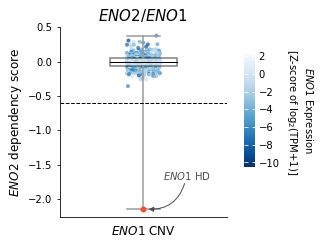

In [12]:
ax, ENO2_ENO1_boxplot = boxplotStripplot_CNV ('ENO2_ENO1', huge_df, rnaseq_zlogtpm, -0.6, label_Chronos = True)
ax.text(0.12, -1.72, '$\it{ENO1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.25, -1.75), xycoords='data', xytext=(0.02, -2.15), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

ENO2_ENO1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/ENO2_ENO1_Chronos.pdf', dpi=400, bbox_inches='tight')

ENO2_ENO1_boxplot

***SMARCC2/SMARCC1***

In [13]:
## SLs list
## putative_SLs_ls
ax, SMARCC2_SMARCC1_boxplot = boxplotStripplot_CNV ('SMARCC2_SMARCC1', huge_df, rnaseq_zlogtpm, -3, label_standard=True)
ax.text(0.16, -5, '$\it{SMARCC1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -5.2), xycoords='data', xytext=(0.02, -7), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

SMARCC2_SMARCC1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/SMARCC2_SMARCC1_standardZ.pdf', dpi=400, bbox_inches='tight')

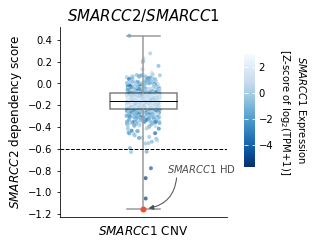

In [13]:
ax, SMARCC2_SMARCC1_boxplot = boxplotStripplot_CNV ('SMARCC2_SMARCC1', huge_df, rnaseq_zlogtpm, -0.6, label_Chronos=True)
ax.text(0.14, -0.82, '$\it{SMARCC1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -0.85), xycoords='data', xytext=(0.02, -1.15), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

SMARCC2_SMARCC1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/SMARCC2_SMARCC1_Chronos.pdf', dpi=400, bbox_inches='tight')
SMARCC2_SMARCC1_boxplot

***POLR3GL/POLR3G***

In [15]:
ax, POLR3GL_POLR3G_boxplot = boxplotStripplot_CNV ('POLR3GL_POLR3G', huge_df, rnaseq_zlogtpm, -3, label_standard=True)
ax.text(0.09, -5, '$\it{POLR3G}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -5.2), xycoords='data', xytext=(0.02, -6.5), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

POLR3GL_POLR3G_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/POLR3GL_POLR3G_standardZ.pdf', dpi=400, bbox_inches='tight')

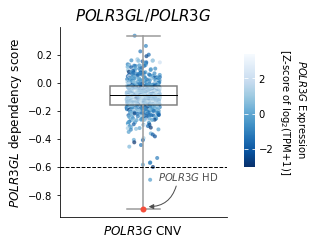

In [14]:
ax, POLR3GL_POLR3G_boxplot = boxplotStripplot_CNV ('POLR3GL_POLR3G', huge_df, rnaseq_zlogtpm, -0.6, label_Chronos=True)
ax.text(0.09, -0.7, '$\it{POLR3G}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -0.72), xycoords='data', xytext=(0.02, -0.88), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

POLR3GL_POLR3G_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/POLR3GL_POLR3G_Chronos.pdf', dpi=400, bbox_inches='tight')
POLR3GL_POLR3G_boxplot

***CAPZA2/CAPZA1***

In [17]:
ax, CAPZA2_CAPZA1_boxplot = boxplotStripplot_CNV ('CAPZA2_CAPZA1', huge_df, rnaseq_zlogtpm, -3, label_standard=True)
ax.text(0.09, -8, '$\it{CAPZA1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -8.2), xycoords='data', xytext=(0.02, -10.3), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

CAPZA2_CAPZA1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/CAPZA2_CAPZA1_standardZ.pdf', dpi=400, bbox_inches='tight')

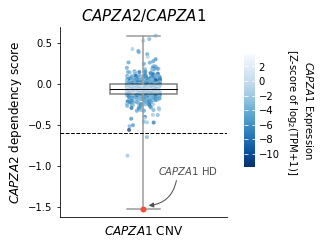

In [15]:
ax, CAPZA2_CAPZA1_boxplot = boxplotStripplot_CNV ('CAPZA2_CAPZA1', huge_df, rnaseq_zlogtpm, -0.6, label_Chronos=True)
ax.text(0.09, -1.1, '$\it{CAPZA1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -1.15), xycoords='data', xytext=(0.02, -1.48), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

CAPZA2_CAPZA1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/CAPZA2_CAPZA1_Chronos.pdf', dpi=400, bbox_inches='tight')
CAPZA2_CAPZA1_boxplot

***CSTF2/CSTF2T***

In [19]:
ax, CSTF2_CSTF2T_boxplot = boxplotStripplot_CNV ('CSTF2_CSTF2T', huge_df, rnaseq_zlogtpm, -3, label_standard=True)
ax.text(0.1, -7, '$\it{CSTF2T}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -7), xycoords='data', xytext=(0.02, -8.5), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

CSTF2_CSTF2T_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/CSTF2_CSTF2T_standardZ.pdf', dpi=400, bbox_inches='tight')

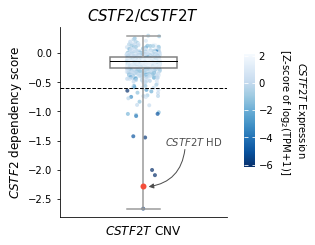

In [16]:
ax, CSTF2_CSTF2T_boxplot = boxplotStripplot_CNV ('CSTF2_CSTF2T', huge_df, rnaseq_zlogtpm, -.6, label_Chronos=True)
ax.text(0.13, -1.6, '$\it{CSTF2T}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.25, -1.62), xycoords='data', xytext=(0.02, -2.3), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

CSTF2_CSTF2T_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/CSTF2_CSTF2T_Chronos.pdf', dpi=100, bbox_inches='tight')
CSTF2_CSTF2T_boxplot

***CNOT8/CNOT7***

In [21]:
ax, CNOT8_CNOT7_boxplot = boxplotStripplot_CNV ('CNOT8_CNOT7', huge_df, rnaseq_zlogtpm, -3, label_standard=True)
ax.text(0.1, -6.5, '$\it{CNOT7}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -6.8), xycoords='data', xytext=(0.02, -8.5), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))
CNOT8_CNOT7_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/CNOT8_CNOT7_standardZ.pdf', dpi=400, bbox_inches='tight')

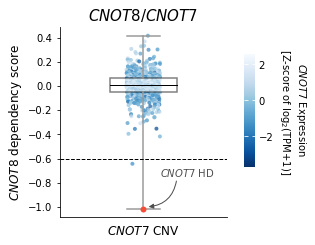

In [17]:
ax, CNOT8_CNOT7_boxplot = boxplotStripplot_CNV ('CNOT8_CNOT7', huge_df, rnaseq_zlogtpm, -.6, label_Chronos=True)
ax.text(0.1, -.75, '$\it{CNOT7}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.2, -.77), xycoords='data', xytext=(0.02, -1), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))
CNOT8_CNOT7_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/CNOT8_CNOT7_Chronos.pdf', dpi=400, bbox_inches='tight')
CNOT8_CNOT7_boxplot

***NXT1/NXT2***

In [23]:
ax, NXT1_NXT2_boxplot = boxplotStripplot_CNV ('NXT1_NXT2', huge_df, rnaseq_zlogtpm, -3, label_standard=True)
ax.text(0.25, -2, '$\it{NXT2}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.4, -2.2), xycoords='data', xytext=(0.02, -4.2), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))
NXT1_NXT2_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/NXT1_NXT2_standardZ.pdf', dpi=400, bbox_inches='tight')

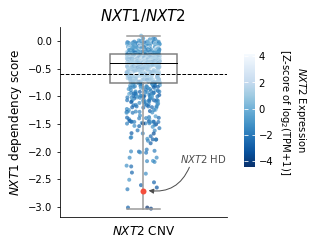

In [18]:
ax, NXT1_NXT2_boxplot = boxplotStripplot_CNV ('NXT1_NXT2', huge_df, rnaseq_zlogtpm, -.6, label_Chronos=True)
ax.text(0.22, -2.2, '$\it{NXT2}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.28, -2.25), xycoords='data', xytext=(0.02, -2.7), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))
NXT1_NXT2_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/NXT1_NXT2_Chronos.pdf', dpi=400, bbox_inches='tight')
NXT1_NXT2_boxplot

***TLK2/TLK1***

In [25]:
ax, TLK2_TLK1_boxplot = boxplotStripplot_CNV('TLK2_TLK1', huge_df, rnaseq_zlogtpm, -3, label_standard=True)
ax.text(0.25, -2, '$\it{TLK1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.4, -2.2), xycoords='data', xytext=(0.02, -4.7), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

TLK2_TLK1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/TLK2_TLK1_standardZ.pdf', dpi=400, bbox_inches='tight')

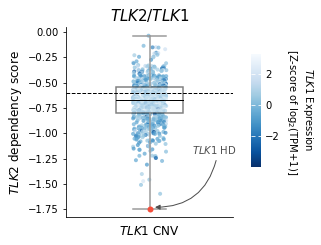

In [19]:
ax, TLK2_TLK1_boxplot = boxplotStripplot_CNV('TLK2_TLK1', huge_df, rnaseq_zlogtpm, -.6, label_Chronos=True)
ax.text(0.25, -1.2, '$\it{TLK1}$ HD', fontsize=10, color='#4D4D4D')
ax.annotate("", xy=(0.4, -1.25), xycoords='data', xytext=(0.02, -1.73), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

TLK2_TLK1_boxplot.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/TLK2_TLK1_Chronos.pdf', dpi=400, bbox_inches='tight')
TLK2_TLK1_boxplot

### Demonstration in workflow graph

In [14]:
plot_df = huge_df[huge_df.pairs_to_test_symbol == 'ENO2_ENO1'].reset_index(drop=True)


plot_df.loc[plot_df['A2_CNV'] == 'Others','simul_score'] = np.random.uniform(0.3, -0.3, plot_df.shape[0]-1)
plot_df.loc[plot_df['A2_CNV'] == 'Homozygous deletion','simul_score'] = -1

plot_df[:2]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol,BROAD_ID,A2_CNV,A1_Chronosscore,A1_StandardZscore,A1_RobustZscore,A1_Ranking,simul_score
0,ENO1_ENO2,ENO2,ENO1,2026,2023,ENSG00000111674,ENSG00000074800,ENO1,2026-2023,ENO2_ENO1,ACH-000948,Others,0.012144,0.186938,0.261859,281.0,0.082891
1,ENO1_ENO2,ENO2,ENO1,2026,2023,ENSG00000111674,ENSG00000074800,ENO1,2026-2023,ENO2_ENO1,ACH-000011,Others,-0.249183,-1.952084,-2.873180,699.0,-0.263848


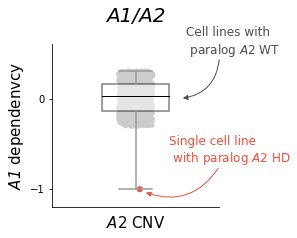

In [16]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))

ax = sns.stripplot(x="A2_hgnc_symbol", y='simul_score', ax = ax, data = plot_df,
                   size = 6, linewidth = 0, hue = 'A2_CNV', hue_order=['Homozygous deletion', 'Others'], 
                   palette=['#F44E3B', '#CCCCCC'], jitter = 0.1, zorder = 0)

# Plot boxplot
ax = sns.boxplot(x="A2_hgnc_symbol", y='simul_score', ax = ax, data = plot_df, 
                 whis=[0,100], width = 0.4, linewidth = 1.5, palette = ['white'],
                 saturation=0.8, boxprops=dict(alpha=0.5, edgecolor='black'), 
                 medianprops=dict(linewidth=1, color='black'))

## Figure format
# Hide X axis label and ticks
ax.tick_params(axis='x', which='both', length=0); ax.set_xticklabels([]) 
plt.yticks([0,-1])
ax.set_ylim([-1.2,0.6])
# Set x and y axes labels
ax.set_xlabel('$\it{A2}$'+' CNV', fontsize=15); ax.set_ylabel('A1 $\\rm{dependenvcy}$', fontstyle='italic', fontsize=15)
# Spine of the plot 
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
# Title of the plot
ax.set_title('A1/A2', fontstyle = 'italic', fontsize = 20, y = 1.1)

ax.get_legend().remove()

ax.text(0.2, -0.7, 'Single cell line \n with paralog $\it{A2}$ HD', fontsize=12, color='#F44E3B')
ax.annotate("", xy=(0.5, -0.75), xycoords='data', xytext=(0.05, -1.03), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#F44E3B"))


ax.text(0.3, 0.5, 'Cell lines with \n paralog $\it{A2}$ WT', fontsize=12, color='#4D4D4D')
ax.annotate("", xy=(0.5, 0.45), xycoords='data', xytext=(0.27, 0), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#4D4D4D"))

f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/06_identify_SL_interaction_pairs_filtering/demo.pdf', dpi = 400, bbox_inches='tight')